In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
M = np.load('/content/drive/MyDrive/deep_learning_projects/Image_captioning/Models_/embedB.npy')
cap_seq = np.load('/content/drive/MyDrive/deep_learning_projects/Image_captioning/Models_/caption_vec.npy')

import pickle

word_ind_map=dict()
with open('/content/drive/MyDrive/deep_learning_projects/Image_captioning/Models_/word_ind_map.pkl', 'rb') as f:
  word_ind_map = pickle.load(f)

ind_word_map=dict()
with open('/content/drive/MyDrive/deep_learning_projects/Image_captioning/Models_/ind_word_map.pkl', 'rb') as f:
  ind_word_map = pickle.load(f)

IV3_feat = tf.keras.models.load_model('/content/drive/MyDrive/deep_learning_projects/Image_captioning/Models_/IV3_feat.h5')

In [24]:
#To test on images external to Flickr30K dataset
image_path = '/content/drive/MyDrive/deep_learning_projects/Image_captioning/local_images/'
#version = '5'

In [5]:
feat_path = '/content/drive/MyDrive/deep_learning_projects/Image_captioning/data/image_feat'
text_path = '/content/drive/MyDrive/deep_learning_projects/Image_captioning/data/captions_pros.csv'

In [6]:
class ENCODER(tf.keras.Model):
  def __init__(self, embed_dim):
    super(ENCODER,self).__init__()
    self.den = tf.keras.layers.Dense(embed_dim)

  def call(self, x):
    x = self.den(x)
    x = tf.nn.relu(x)
    return x

In [7]:
class ATTEND(tf.keras.Model):
  def __init__(self, units):
    super(ATTEND, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, feat, hidden):
    hidden_ = tf.expand_dims(hidden, axis=1)
    score = tf.nn.tanh( self.W1(feat) + self.W2(hidden_) )
    att_wt = tf.nn.softmax(self.V(score), axis=1)
    context = att_wt*feat
    context = tf.reduce_sum(context, axis=1)

    return context, att_wt

In [8]:
class DECODER(tf.keras.Model):

  def __init__(self, units, embed_M, sentence_length):
    super(DECODER, self).__init__()
    self.units = units
    self.embed = tf.keras.layers.Embedding(input_dim=embed_M.shape[0], output_dim=embed_M.shape[1], weights=[embed_M], input_length=sentence_length, trainable=False )
    #self.embed = tf.keras.layers.Embedding(input_dim=embed_M.shape[0], output_dim=embed_M.shape[1], embeddings_initializer=tf.keras.initializers.Constant(embed_M), input_length=sentence_length, trainable=True)
    self.lstm = tf.keras.layers.LSTM(units=units, return_sequences=True, return_state=True)
    self.den1 = tf.keras.layers.Dense(units)
    self.den2 = tf.keras.layers.Dense(embed_M.shape[0])
    self.attend = ATTEND(units)

  def call(self, tok, feat, hidden):
    context, att_wt = self.attend(feat, hidden)
    x = self.embed(tok)
    context_ = tf.expand_dims(context,1)
    x = tf.concat([context_, x], axis=2)
    output, state, _ = self.lstm(x)
    x = self.den1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.den2(x)
    return x, state, att_wt

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [9]:
embed_dim = 300
units = 512
enc = ENCODER(embed_dim)
dec = DECODER(units, M, 80)

In [14]:
enc.load_weights("/content/drive/MyDrive/deep_learning_projects/Image_captioning/Models_/enc_dec/encoder_5/5/")
dec.load_weights("/content/drive/MyDrive/deep_learning_projects/Image_captioning/Models_/enc_dec/decoder_5/5/")


In [15]:
from PIL import Image


In [16]:
def load_image(arg):
    img = tf.io.read_file(arg)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, arg

In [17]:
max_length = 80
def evaluate(image): #This part is similar to a single train step except that we record attention weights and don't use teacher forcing
    attention_plot = np.zeros((max_length, 64))

    hidden = dec.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image_path + image)[0], 0)
    img_tensor_val = IV3_feat(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = enc(img_tensor_val)

    dec_input = tf.expand_dims([word_ind_map['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = dec(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()#print shape

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(ind_word_map[predicted_id])

        if ind_word_map[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0) #while training we use teacher forcing, but while testing we obviously feed predicted token to the next time step of dec

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [18]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image_path + image))

    fig = plt.figure(figsize=(10, 10),dpi=200)

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [19]:
def plot_attention_save(image, im, k, result, attention_plot):
    temp_image = np.array(im)
    plt.ioff()
    fig = plt.figure(figsize=(10, 10),dpi=200)
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
    plt.tight_layout()
    plt.savefig(result_path + image[0:-4] + '_pred' + str(k) + '.png' )

215


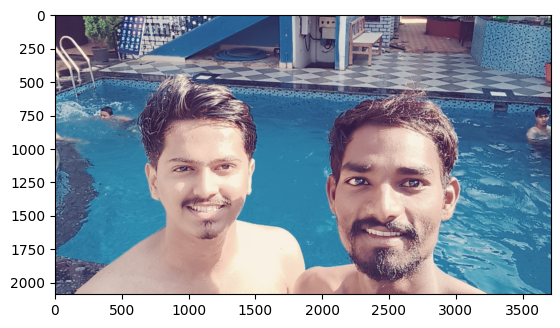

In [22]:
#Below we are testing model on 5 different images

rid = np.random.randint(0, 400)
print(rid)
plt.imshow(Image.open("/content/drive/MyDrive/deep_learning_projects/Image_captioning/local_images/1701523324971.jpg"))

In [26]:
image = "1701523324971.jpg"
# real_caption = ' '.join([ind_word_map[i] for i in y_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

bl = True
while(bl): #sanity check (avoiding predictions having > 20 words)
  if(len(result)<=20):
    bl =False
  else:
    result, attention_plot = evaluate(image)

# print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image, result, attention_plot)

Prediction Caption: a man smiling a play in the pool <end>


265


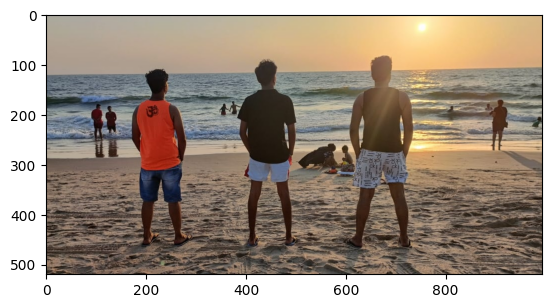

In [28]:
#Below we are testing model on 5 different images

rid = np.random.randint(0, 400)
print(rid)
plt.imshow(Image.open("/content/drive/MyDrive/deep_learning_projects/Image_captioning/local_images/goa_pic.jpg"))

In [84]:
image = "goa_pic.jpg"
# real_caption = ' '.join([ind_word_map[i] for i in y_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

bl = True
while(bl): #sanity check (avoiding predictions having > 20 words)
  if(len(result)<=20):
    bl =False
  else:
    result, attention_plot = evaluate(image)

# print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image, result, attention_plot)

Prediction Caption: two children playing at the beach <end>
